# Step-49

This is a replica of [step-49](https://www.dealii.org/current/doxygen/deal.II/step_49.html) C++ tutorial program. However, here we will use the deal.II Python interface to achieve the same. 

Not all of the material is replicated since some parts of the original C++ tutorial are only relevant when using C++. Furthermore, in contrast to the C++ program, here we will take advantage of Jupyter notebook format and do coding and visualization in place.

*This notebook is contributed by Alexander Grayver, 2020*

## Python initialization

Provided the deal.II was compiled with the python wrappers, we can import the module **PyDealII**. Note that it is only a shell and importing it will only allow you to call
```python 
help(PyDealII)
``` 
**PyDealII** is composed of two libraries: 
 - **PyDealII.Debug** which uses the debug version of **deal.II**
 - **PyDealII.Release** which uses the release version of **deal.II**
 
Let's us import the release version of the library and give it the shortname **dealii**

In [1]:
import PyDealII.Release as dealii

In addition, we will import a few widely used python packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import re
import math

%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

Finally, here are a couple of functions, which we will use to plot a triangulation or print some information about it:

In [3]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def plot_triangulation(triangulation, color_scheme = None):
    fig, ax = plt.subplots()
    patches = []
    colors = []
    cell_id = 0 
    for cell in triangulation.active_cells():
        quad_vertices = np.zeros((4,2))
        # The shift variable is used to reorder the vertices because
        # deal.II and matplotlib require different ordering
        shift = [0,1,3,2]
        for i in range(4):
            vertex = cell.get_vertex(i)
            quad_vertices[shift[i]][0] = vertex.x
            quad_vertices[shift[i]][1] = vertex.y
        quad = Polygon(quad_vertices, closed=True)
        patches.append(quad)
        
        if color_scheme:
            colors.append(color_scheme(cell))

        cell_id += 1
    p = PatchCollection(patches, edgecolors='k', facecolors=None)  
    p.set_array(np.array(colors))
    ax.add_collection(p, autolim=True)
    ax.autoscale_view()
    ax.set_aspect(1)
    plt.show()

ModuleNotFoundError: No module named 'matplotlib'

You don't need to understand internals of these functions, they are used as mere helpers here.

## Introduction

This tutorial is an extension to [step-1](https://www.dealii.org/current/doxygen/deal.II/step_1.html) and demonstrates several ways to obtain more involved meshes than the ones shown there.

Generating complex geometries is a challenging task, especially in three space dimensions. We will discuss several ways to do this, but this list is not exhaustive. Additionally, there is not one approach that fits all problems.

This example program shows some of ways to create and modify meshes for computations and outputs them as .vtu files in much the same way as we do in [step-1](https://www.dealii.org/current/doxygen/deal.II/step_1.html). No other computations or adaptive refinements are done; the idea is that you can use the techniques used here as building blocks in other, more involved simulators. Please note that the example program does not show all the ways to generate meshes that are discussed in this introduction.

### General concerns about meshes

When you use adaptive mesh refinement, you definitely want the initial mesh to be as coarse as possible. The reason is that you can make it as fine as you want using adaptive refinement as long as you have memory and CPU time available. However, this requires that you don't waste mesh cells in parts of the domain where they don't pay off. As a consequence, you don't want to start with a mesh that is too fine to start with, because that takes up a good part of your cell budget already, and because you can't coarsen away cells that are in the initial mesh.

That said, your mesh needs to capture the given geometry adequately.

### How to create meshes

There are several ways to create an initial mesh. Meshes can be modified or combined in many ways as discussed later on.

#### Using Grid Generators

The easiest way to generate meshes is to use the functions from the namespace [GridGenerator](https://www.dealii.org/current/doxygen/deal.II/namespaceGridGenerator.html). Python interface currently supports the following functions 

In [5]:
list(filter(re.compile('generate_*').match, dir(dealii.Triangulation)))

['generate_cheese',
 'generate_enclosed_hyper_cube',
 'generate_fixed_subdivided_parallelepiped',
 'generate_general_cell',
 'generate_half_hyper_ball',
 'generate_hyper_ball',
 'generate_hyper_cube',
 'generate_hyper_cube_with_cylindrical_hole',
 'generate_hyper_rectangle',
 'generate_hyper_shell',
 'generate_hyper_sphere',
 'generate_parallelepiped',
 'generate_parallelogram',
 'generate_quarter_hyper_ball',
 'generate_simplex',
 'generate_subdivided_hyper_cube',
 'generate_subdivided_hyper_rectangle',
 'generate_subdivided_material_hyper_rectangle',
 'generate_subdivided_steps_hyper_rectangle',
 'generate_varying_subdivided_parallelepiped']

#### Importing from external programs

The original C++ class [GridIn](https://www.dealii.org/current/doxygen/deal.II/classGridIn.html) can read many different mesh formats from a file from disk. In PyDealII, GridIn functions are called via the *Triangulation.read* method

In [6]:
help(dealii.Triangulation.read)

Help on built-in function read:

read(...)
    read( (Triangulation)self, (str)filename, (str)format) -> None :
        Read a mesh from the file according to the given data format.          
        The possible formats are:                                              
          - msh                                                                
          - vtk



Meshes can be generated from different tools like [gmsh](http://gmsh.info/), [lagrit](https://lagrit.lanl.gov/) and [cubit](https://cubit.sandia.gov/). See the documentation of [GridIn](https://www.dealii.org/current/doxygen/deal.II/classGridIn.html) for more information. The problem is that deal.II needs meshes that only consist of quadrilaterals and hexahedra – tetrahedral meshes won't work (this means tools like tetgen can not be used directly).

We will describe a possible workflow using Gmsh. Gmsh is the smallest and most quickly set up open source tool we are aware of. It can generate unstructured 2d quad meshes. In 3d, it can extrude 2d meshes to get hexahedral meshes; 3D meshing of unstructured geometry into hexahedra is possible, though there are some issues with the quality of these meshes that imply that these meshes only sometimes work in deal.II.

In Gmsh, a mesh is fundamentally described in a text-based .geo file whose format can contain computations, loops, variables, etc. This format is quite flexible in allowing the description of complex geometries. The mesh is then generated from a surface representation, which is built from a list of line loops, which is built from a list of lines, which are in turn built from points. The .geo script can be written and edited by hand or it can be generated automatically by creating objects graphically inside Gmsh. In many cases it is best to combine both approaches. The file can be easily reloaded by pressing "reload" under the "Geometry" tab if you want to write it by hand and see the effects in the graphical user interface of gmsh.

This tutorial contains an example .geo file that describes a box with two objects cut out in the interior. This is how *example.geo* looks like in Gmsh (displaying the boundary indicators as well as the mesh discussed further down below):

In [7]:
%%html
<img src="https://www.dealii.org/images/steps/developer/step-49.gmsh_picture.png"/>

You might want to open the example.geo file in a text editor (it is located in the same directory as the *step-49.cc* source file) to see how it is structured. You can see how the boundary of the domain is composed of a number of lines and how later on we combine several lines into "physical lines" (or "physical surfaces") that list the logical lines' numbers. "Physical" object are the ones that carry information about the boundary indicator (see [this glossary entry](https://www.dealii.org/developer/doxygen/deal.II/DEALGlossary.html#GlossBoundaryIndicator)).

**Note**
>It is important that this file contain "physical lines" and "physical surfaces". These give the boundary indicators and material ids for use in deal.II. Without these physical entities, nothing will be imported into deal.II.

deal.II's GridIn class can read the .msh format written by Gmsh and that contains a mesh created for the geometry described by the .geo file. You generate the .msh from the .geo by running the commands

```javascript
gmsh -2 example.geo
```

on the command line, or by clicking "Mesh" and then "2D" inside Gmsh after loading the file. Now, we can read in the mesh from the .msh file and visualize using the python bindings:

In [10]:
!(ls)

CMakeLists.txt	Untitled.ipynb	point.ipynb  source	    step-53.ipynb
README.md	notebook	python	     step-49.ipynb  step-62.ipynb


In [8]:
triangulation = dealii.Triangulation(dim = '2D')
triangulation.read(filename = 'example.msh', format = 'msh')
plot_triangulation(triangulation)

RuntimeError: 
--------------------------------------------------------
An error occurred in line <847> of file </tmp/makepkg/deal-ii/src/dealii-9.5.1/contrib/python-bindings/source/triangulation_wrapper.cc> in function
    void dealii::python::internal::read(const std::string&, const std::string&, void*) [with int dim = 2; int spacedim = 2; std::string = std::__cxx11::basic_string<char>]
The violated condition was: 
    ifs
Additional information: 
    An input/output error has occurred. There are a number of reasons why
    this may be happening, both for reading and writing operations.
    
    If this happens during an operation that tries to read data: First,
    you may be trying to read from a file that doesn't exist or that is
    not readable given its file permissions. Second, deal.II uses this
    error at times if it tries to read information from a file but where
    the information in the file does not correspond to the expected
    format. An example would be a truncated file, or a mesh file that
    contains not only sections that describe the vertices and cells, but
    also sections for additional data that deal.II does not understand.
    
    If this happens during an operation that tries to write data: you may
    be trying to write to a file to which file or directory permissions do
    not allow you to write. A typical example is where you specify an
    output file in a directory that does not exist.

Stacktrace:
-----------
#0  /usr/lib/python3.11/site-packages/PyDealII/Release.so: void dealii::python::internal::read<2, 2>(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, void*)
#1  /usr/lib/python3.11/site-packages/PyDealII/Release.so: boost::python::objects::caller_py_function_impl<boost::python::detail::caller<void (dealii::python::TriangulationWrapper::*)(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >) const, boost::python::default_call_policies, boost::mpl::vector4<void, dealii::python::TriangulationWrapper&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > >::operator()(_object*, _object*)
#2  /usr/lib/libboost_python311.so.1.83.0: boost::python::objects::function::call(_object*, _object*) const
#3  /usr/lib/libboost_python311.so.1.83.0: 
#4  /usr/lib/libboost_python311.so.1.83.0: boost::python::handle_exception_impl(boost::function0<void>)
#5  /usr/lib/libboost_python311.so.1.83.0: 
#6  /usr/lib/libpython3.11.so.1.0: _PyObject_MakeTpCall
#7  /usr/lib/libpython3.11.so.1.0: _PyEval_EvalFrameDefault
#8  /usr/lib/libpython3.11.so.1.0: 
#9  /usr/lib/libpython3.11.so.1.0: PyEval_EvalCode
#10  /usr/lib/libpython3.11.so.1.0: 
#11  /usr/lib/libpython3.11.so.1.0: _PyEval_EvalFrameDefault
#12  /usr/lib/libpython3.11.so.1.0: 
#13  /usr/lib/libpython3.11.so.1.0: _PyEval_EvalFrameDefault
#14  /usr/lib/libpython3.11.so.1.0: 
#15  /usr/lib/libpython3.11.so.1.0: _PyEval_EvalFrameDefault
#16  /usr/lib/libpython3.11.so.1.0: 
#17  /usr/lib/libpython3.11.so.1.0: 
#18  /usr/lib/libpython3.11.so.1.0: _PyEval_EvalFrameDefault
#19  /usr/lib/libpython3.11.so.1.0: 
#20  /usr/lib/libpython3.11.so.1.0: 
#21  /usr/lib/libpython3.11.so.1.0: PyObject_Call
#22  /usr/lib/libpython3.11.so.1.0: _PyEval_EvalFrameDefault
#23  /usr/lib/libpython3.11.so.1.0: 
--------------------------------------------------------


**Note**
> gmsh has a number of other interfaces by which one can describe geometries to it. In particular, it has the ability to interface with scripting languages like Python and Julia, but it can also be scripted from C++. These interfaces are useful if one doesn't just want to generate a mesh for a single geometry (in which case the graphical interface or, in simple cases, a hand-written .geo file is probably the simplest approach), but instead wants to do parametric studies over the geometry for which it is necessary to generate many meshes for geometries that differ in certain parameters. Another case where this is useful is if there is already a CAD geometry for which one only needs a mesh; indeed, this can be done from within deal.II using the [Gmsh::create_triangulation_from_boundary_curve()](https://www.dealii.org/current/doxygen/deal.II/namespaceGmsh.html#ab65eb217368d006b66bcfcc6fa0f2894) function.

### Modifying a Mesh

After acquiring one (or several) meshes in the ways described above, there are many ways to manipulate them before using them in a finite element computation.

#### Transformations

The function *Triangulation.transform* allows you to transform the vertices of a given mesh using a smooth function. An example of its use is also given in the results section of [step-38](https://www.dealii.org/current/doxygen/deal.II/step_38.html) but let us show a simpler example here. Using the code below, we perturb the *y* coordinate of a mesh with a sine curve.

First, let us create a triangulation

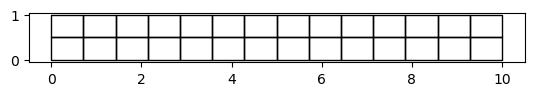

In [11]:
triangulation = dealii.Triangulation('2D')
triangulation.generate_subdivided_hyper_rectangle(repetitions = [14, 2],\
                                                  p1 = dealii.Point([0, 0]),\
                                                  p2 = dealii.Point([10, 1]))
plot_triangulation(triangulation)

Next, we define a lambda function that takes a point (a list of size *dim* with coordinates), transforms it according to the formula $(x,y) \rightarrow (x, y + \sin(\pi x / 5))$ and returns the result:

In [12]:
sine_y_transform = lambda p: [p[0], p[1] + math.sin(p[0] / 5.0 * math.pi)]

Now, apply this transformation and plot the result:

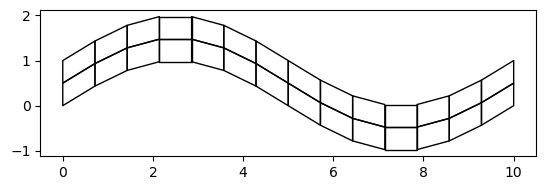

In [13]:
triangulation.transform(transformation = sine_y_transform)
plot_triangulation(triangulation)

Similarly, we can transform a regularly refined unit square to a wall-adapted mesh in y direction using the formula $(x,y) \rightarrow (x, \tanh(2y) / \tanh(2))$:

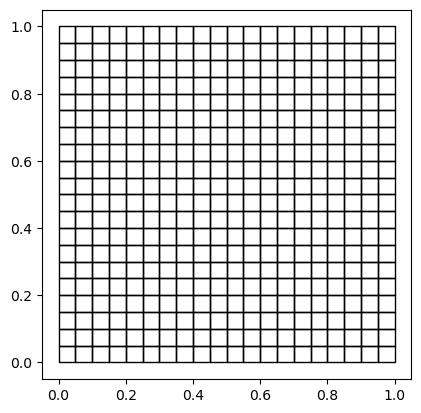

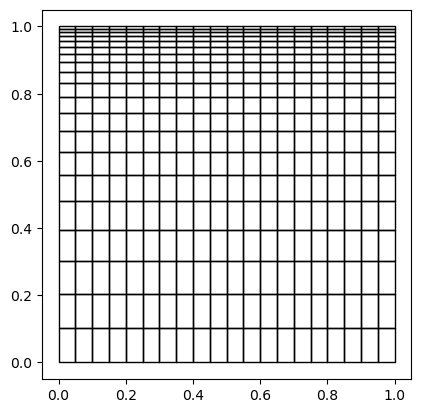

In [14]:
triangulation = dealii.Triangulation('2D')
triangulation.generate_subdivided_hyper_rectangle(repetitions = [20, 20],\
                                                  p1 = dealii.Point([0, 0]),\
                                                  p2 = dealii.Point([1, 1]))
plot_triangulation(triangulation)

tanh_y_transform = lambda p: [p[0], math.tanh(2. * p[1]) / math.tanh(2.)]
triangulation.transform(transformation = tanh_y_transform)

plot_triangulation(triangulation)

Finally, the function *distort_random* allows you to move vertices in the mesh (optionally ignoring boundary nodes) by a random amount. This is demonstrated in below:

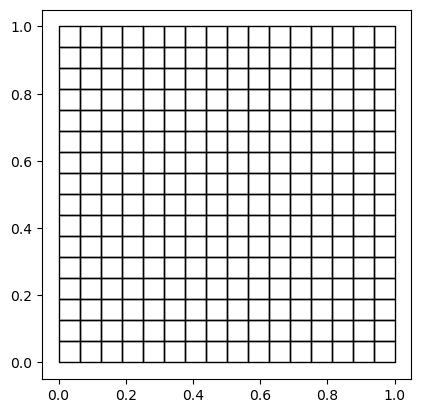

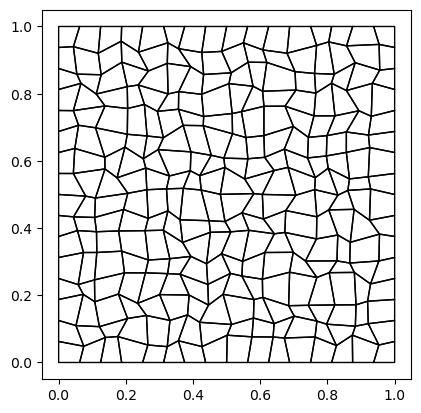

In [15]:
triangulation = dealii.Triangulation('2D')
triangulation.generate_subdivided_hyper_rectangle(repetitions = [16, 16],\
                                                  p1 = dealii.Point([0, 0]),\
                                                  p2 = dealii.Point([1, 1]))
plot_triangulation(triangulation)

triangulation.distort_random(factor = 0.3, keep_boundary = True)

plot_triangulation(triangulation)

This function is primarily intended to negate some of the superconvergence effects one gets when studying convergence on regular meshes, as well as to suppress some optimizations in deal.II that can exploit the fact that cells are similar in shape. (Superconvergence refers to the fact that if a mesh has certain symmetries – for example, if the edges running into a vertex are symmetric to this vertex, and if this is so for all vertices of a cell – that the solution is then often convergent with a higher order than one would have expected from the usual error analysis. In the end, this is a result of the fact that if one were to make a Taylor expansion of the error, the symmetry leads to the fact that the expected next term of the expansion happens to be zero, and the error order is determined by the second next term. A distorted mesh does not have these symmetries and consequently the error reflects what one will see when solving the equation on any kind of mesh, rather than showing something that is only reflective of a particular situation.)

#### Merging Meshes

The method *Triangulation.merge_triangulations* allows you to merge two given *Triangulation* objects into a single one. For this to work, the vertices of the shared edge or face have to match exactly. Lining up the two meshes can be achieved using *Triangulation.shift* and *Triangulation.scale*. In the code section below, we merge a square with a round hole. The method *Triangulation.subdivided_hyper_rectangle* allows you to specify the number of repetitions and the positions of the corners, so there is no need to shift the triangulation manually here. You should inspect the mesh graphically to make sure that cells line up correctly and no unpaired nodes exist in the merged Triangulation.

Create and plot the input meshes:

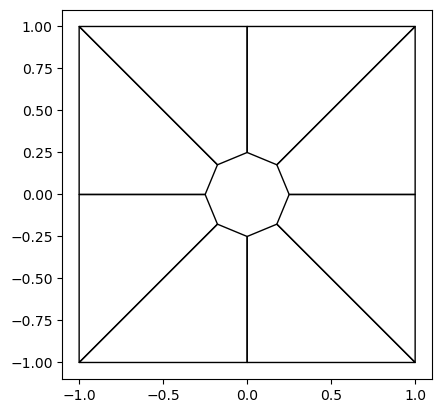

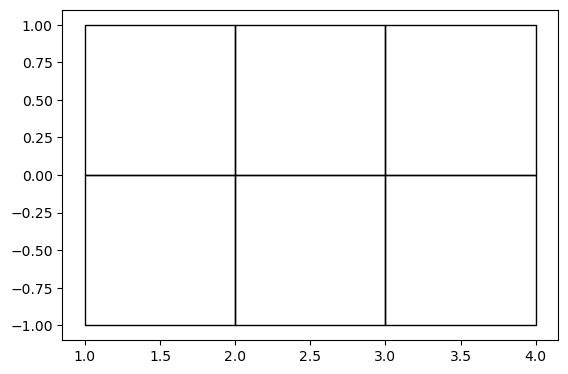

In [16]:
tria_1 = dealii.Triangulation('2D')
tria_1.generate_hyper_cube_with_cylindrical_hole(inner_radius = .25, outer_radius = 1.)

plot_triangulation(tria_1)

tria_2 = dealii.Triangulation('2D')
tria_2.generate_subdivided_hyper_rectangle(repetitions = [3, 2],\
                                           p1 = dealii.Point([1., -1.]),\
                                           p2 = dealii.Point([4., 1.]))
plot_triangulation(tria_2)

Now merge triangulations and plot the resulting mesh

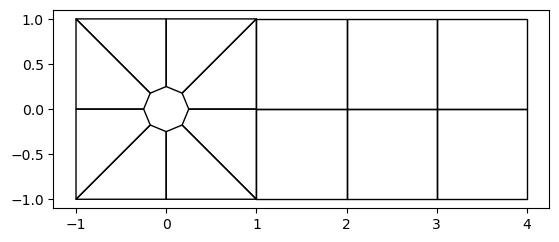

In [17]:
tria_merged = dealii.Triangulation('2D')
tria_merged.merge_triangulations([tria_1, tria_2])
plot_triangulation(tria_merged)

#### Moving Vertices

Here we show the ability to pick individual vertices and move them around in an existing mesh. Note that this has the potential to produce degenerate or inverted cells and you shouldn't expect anything useful to come of using such meshes. Here, we create a box with a cylindrical hole that is not exactly centered by moving the top vertices upwards:

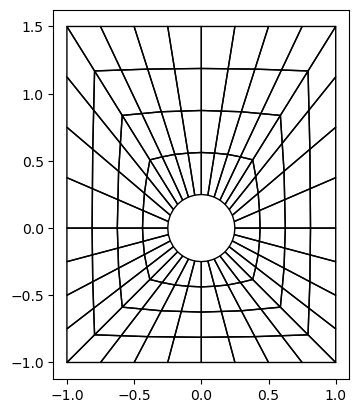

In [18]:
triangulation = dealii.Triangulation('2D')
triangulation.generate_hyper_cube_with_cylindrical_hole(inner_radius = .25, outer_radius = 1.)

for cell in triangulation.active_cells():
    for i in range(4):
        v = cell.get_vertex(i)
        
        if(abs(v.y - 1.0) < 1e-5):
            v.y += 0.5
            
        cell.set_vertex(i, v)
        
triangulation.refine_global(2)

plot_triangulation(triangulation)

#### Extruding Meshes

If you need a 3d mesh that can be created by extruding a given 2d mesh (that can be created in any of the ways given above), you can use the function *Triangulation.extrude_triangulation*. See code below for an example. Note that for this particular case, the given result could also be achieved using the 3d version of *Triangulation.generate_hyper_cube_with_cylindrical_hole*. The main usage is a 2d mesh, generated for example with Gmsh, that is read in from a .msh file as described above.

In [19]:
tria = dealii.Triangulation('2D')
tria.generate_hyper_cube_with_cylindrical_hole(inner_radius = .25, outer_radius = 1.)

tria_extruded = dealii.Triangulation('3D')
tria.extrude_triangulation(n_slices = 3, depth = 2.0, tria_out = tria_extruded)

Since we cannot easily visualize 3d mesh, let's save it in the EPS format and then plot the image (this requires *pillow* package to be installed)

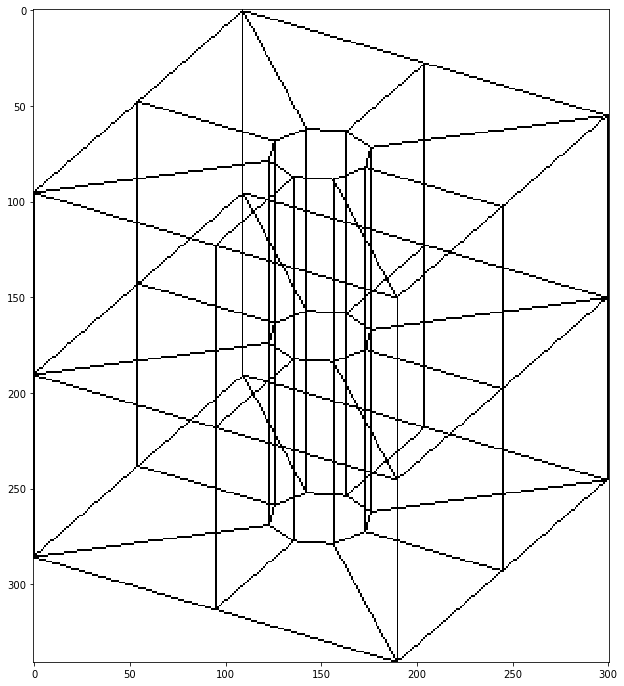

In [17]:
tria_extruded.write('extruded_mesh.eps', format = 'eps')
img = matplotlib.image.imread('extruded_mesh.eps')

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, interpolation='none')

#### After you have a coarse mesh

Creating a coarse mesh using the methods discussed above is only the first step. When you have it, it will typically serve as the basis for further mesh refinement. This is not difficult — in fact, there is nothing else to do — if your geometry consists of only straight faces. However, this is often not the case if you have a more complex geometry and more steps than just creating the mesh are necessary. We will go over some of these steps in the section below.

### Next steps: Curved Cells

As mentioned in the introduction, creating a coarse mesh using the methods discussed here is only the first step. In order to refine a mesh, the *Triangulation* needs to know where to put new vertices on the mid-points of edges, faces, and cells. By default, these new points will be placed at the arithmetic mean of the surrounding points, but this isn't what you want if you need curved boundaries that aren't already adequately resolved by the coarse mesh. 

To illustrate this process in more detail, let us consider an example created by Yuhan Zhou as part of a 2013 semester project at Texas A&M University. The goal was to generate (and use) a geometry that describes a microstructured electric device. In a CAD program, the geometry looks like this:

In [18]:
%%html
<img src="https://www.dealii.org/images/steps/developer/step-49.yuhan.1.png">

In the following, we will walk you through the entire process of creating a mesh for this geometry, including a number of common pitfalls by showing the things that can go wrong.

The first step in getting there was to create a coarse mesh, which was done by creating a 2d coarse mesh for each of cross sections, extruding them into the third direction, and gluing them together. The following code does this, using the techniques previously described:

In [19]:
def create_3d_grid():
    # Generate first cross section
    vertices_1 = [[-1.5, 0.], [-0.5, 0.], [0.5, 0.], [1.5, 0.],\
              [-1.5, 1.5], [-0.5, 1.5], [0.5, 1.5], [1.5, 1.5],\
              [-1.5, 3.], [-0.5, 3.], [0.5, 3.], [1.5, 3.],\
              [-0.5, 3 + 0.5 * math.sqrt(3)],\
              [0.5, 3 + 0.5 * math.sqrt(3)],\
              [-0.75, 3 + 0.75 * math.sqrt(3)],\
              [0.75, 3 + 0.75 * math.sqrt(3)]]

    cell_vertices_1 = [[0, 1, 4, 5],
                   [1, 2, 5, 6],
                   [3, 7, 2, 6],
                   [4, 5, 8, 9],
                   [5, 6, 9, 10],
                   [7, 11, 6, 10],
                   [8, 9, 14, 12],
                   [9, 10, 12, 13],
                   [11, 15, 10, 13],
                   [14, 12, 15, 13]]

    # Given a list of points and how vertices connect to cells, create a mesh.
    tria_2d_1 = dealii.Triangulation('2D')
    tria_2d_1.create_triangulation(vertices_1, cell_vertices_1)

    # Then extrude it into a 3d piece
    tria_3d_1 = dealii.Triangulation('3D')
    tria_2d_1.extrude_triangulation(n_slices = 5, depth = 2.5, tria_out = tria_3d_1)

    # Now do the same with the second volume
    vertices_2 = [[-2.5, 0.],
              [-1.5, 0.],
              [-0.5, 0.],
              [0.5, 0.],
              [1.5, 0.],
              [2.5, 0.],
              [-2.5, 1.5],
              [-1.5, 1.5],
              [-0.5, 1.5],
              [0.5, 1.5],
              [1.5, 1.5],
              [2.5, 1.5],
              [-2.5, 3.],
              [-1.5, 3.],
              [-0.5, 3.],
              [0.5, 3.],
              [1.5, 3.],
              [2.5, 3.],
              [-0.5, 3. + 0.5 * math.sqrt(3)],
              [0.5, 3. + 0.5 * math.sqrt(3)],
              [-0.75, 3. + 0.75 * math.sqrt(3)],
              [0.75, 3. + 0.75 * math.sqrt(3)],
              [-1.25, 3. + 1.25 * math.sqrt(3)],
              [1.25, 3. + 1.25 * math.sqrt(3)]]

    cell_vertices_2 = [[0, 1, 6, 7],
                   [1, 2, 7, 8],
                   [2, 3, 8, 9],
                   [4, 10, 3, 9],
                   [5, 11, 4, 10],
                   [6, 7, 12, 13],
                   [7, 8, 13, 14],
                   [8, 9, 14, 15],
                   [10, 16, 9, 15],
                   [11, 17, 10, 16],
                   [12, 13, 22, 20],
                   [13, 14, 20, 18],
                   [14, 15, 18, 19],
                   [16, 21, 15, 19],
                   [17, 23, 16, 21],
                   [20, 18, 21, 19],
                   [22, 20, 23, 21]]

    tria_2d_2 = dealii.Triangulation('2D')
    tria_2d_2.create_triangulation(vertices_2, cell_vertices_2)

    tria_3d_2 = dealii.Triangulation('3D')
    tria_2d_2.extrude_triangulation(n_slices = 5, depth = 2.5, tria_out = tria_3d_2)

    # Also shift this triangulation in the z-direction so that it matches the
    # end face of the first part
    tria_3d_2.shift([0, 0, 2.5])

    # Now first merge these two pieces, then shift the first piece in
    # z-direction beyond the second, and merge the shifted piece with the two
    # previously merged one into the final one:
    tria_3d_tmp = dealii.Triangulation('3D')
    tria_3d_tmp.merge_triangulations(tria_3d_1, tria_3d_2)

    tria_3d_1.shift([0, 0, 5.])

    triangulation = dealii.Triangulation('3D')
    triangulation.merge_triangulations(tria_3d_tmp, tria_3d_1)

    return triangulation

triangulation = create_3d_grid()
# triangulation.write('coarse.vtk', 'vtk')

This creates the following mesh:

In [20]:
%%html
<img src="https://www.dealii.org/images/steps/developer/step-49.yuhan.8.png">

This mesh has the right general shape, but the top cells are now polygonal: their edges are no longer along circles and we do not have a very accurate representation of the original geometry. The next step is to teach the top part of the domain that it should be curved. Put another way, all calculations done on the top boundary cells should be done in cylindrical coordinates rather than Cartesian coordinates. We can do this by creating a *CylindricalManifold* object and associating it with the cells above $y=3$. This way, when we refine the cells on top, we will place new points along concentric circles instead of straight lines.

In this case, with the CylindricalManifold constructed below, the geodesics are arcs along circles orthogonal to the $z$-axis centered along the line $(0,3,z)$.

Since all three top parts of the domain use the same geodesics, we will mark all cells with centers above the $y=3$ line as being cylindrical in nature:

In [21]:
triangulation = create_3d_grid()

cylinder = dealii.Manifold(dim = 3, spacedim = 3)
cylinder.create_cylindrical(direction = [0., 0., 1.], axial_point = [0, 3., 0.])

cylinder_id = 8

triangulation.set_manifold(number = cylinder_id, manifold = cylinder)

for cell in triangulation.active_cells():
    if cell.center().y >= 3.:
        cell.set_all_manifold_ids(cylinder_id)
        
triangulation.refine_global(1)

triangulation.write('coarse.vtk', 'vtk')

With this code, we get a mesh that looks like this:

In [22]:
%%html
<img src="https://www.dealii.org/images/steps/developer/step-49.yuhan.9.png">

This change fixes the boundary but creates a new problem: the cells adjacent to the cylinder's axis are badly distorted. We should use Cartesian coordinates for calculations on these central cells to avoid this issue. The cells along the center line all have a face that touches the line $(0,3,z)$ so, to implement this, we go back and overwrite the manifold_ids on these cells to be zero (which is the default):

In [23]:
triangulation = create_3d_grid()

triangulation.set_manifold(number = cylinder_id, manifold = cylinder)

for cell in triangulation.active_cells():
    if cell.center().y >= 3.:
        cell.set_all_manifold_ids(cylinder_id)
        
flat_manifold_id = -1
for cell in triangulation.active_cells():
    for face in cell.faces():
        face_center = face.center()
        if abs(face_center.x) < 1.0e-5 and\
           abs(face_center.y - 3.0) < 1.0e-5:
            cell.set_all_manifold_ids(flat_manifold_id)
        
triangulation.refine_global(3)

We can finally save the mesh now:

In [24]:
triangulation.write('final.vtk', 'vtk')

This gives us a good mesh, where cells at the center of each circle are still Cartesian and cells around the boundary lie along a circle. We can really see the nice detail of the boundary fitted mesh if we refine two more times:

In [25]:
%%html
<img src="https://www.dealii.org/images/steps/developer/step-49.yuhan.11.png">